In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sbn # For nice looking plots.

import numpy as np
import scipy as sp
import scipy.io

import os
import copy
import time
import datetime

import tensorflow as tf

import sklearn
import sklearn.ensemble
import sklearn.preprocessing
import sklearn.svm

import time

np.set_printoptions(precision=2, suppress=True, linewidth=140)

In [2]:
# Load the training and test data
sarcos_inv = scipy.io.loadmat('../data/sarcos_inv.mat')['sarcos_inv']
sarcos_inv_test = scipy.io.loadmat('../data/sarcos_inv_test.mat')['sarcos_inv_test']

scaler_x = None
scaler_y = None

def split_data(data, timesteps=1, train_scaler=False):
    global scaler_x, scaler_y
    
    X, Y = np.split(data, [21], axis=1)
    
    if timesteps == 1:
        Xres, Yres = X, Y
    else:
        Xres = np.zeros((X.shape[0] - timesteps + 1, 21 * timesteps))
        Yres = Y[timesteps - 1:]
    
    for i in xrange(X.shape[0] - timesteps + 1):
        Xres[i] = np.reshape(X[i:i+timesteps], -1)
        
    if train_scaler:
        scaler_x = sklearn.preprocessing.StandardScaler()
        scaler_y = sklearn.preprocessing.StandardScaler()
        scaler_x.fit(Xres)
        scaler_y.fit(Yres)
    
    if scaler_x is not None:
        return scaler_x.transform(Xres), scaler_y.transform(Yres)
    
    return Xres, Yres


In [ ]:
class MultidimSVR(object):
    def __init__(self, param):
        self.param = param
        
    def fit(self, X, Y, verbose=False):
        if verbose:
            print 'Start fitting SVR:'
        self.models = []
        for yi in xrange(Y.shape[1]):
            start = time.time()
            model = sklearn.svm.SVR(**self.param)
            model.fit(X, Y[:, yi])
            self.models.append(model)
            
            if verbose:
                print '  (SVR %d fit took %.1f sec)' % (yi, time.time() - start)
            
    def predict(self, X, verbose=False):
        res = []
        start = time.time()
        for model in self.models:
            res.append(model.predict(X))
            
        if verbose:
            print '(Total prediction took %.1f sec)' % (time.time() - start)
        
            
        return np.column_stack(res)

# Train support vector regression with different tree depth and n_estimators

In [5]:
import  sklearn.model_selection 

# Training with different tree depth
total_params = []

for history_steps in [3, 1]:
    params = []
    for C in [0.1, 1.0, 10., 20]:
        for epsilon in [1e-4, 0.001, 0.01, 0.1, 1.0]:
            params.append({
                'model': {
                    'C': C,
                    'epsilon': epsilon,
                    'verbose': True                    
                },
                'history_steps': history_steps,
                'time': 0.
            })

    X, Y = split_data(sarcos_inv, train_scaler=True, timesteps=history_steps)

    pert = np.random.permutation(X.shape[0])
    X = X[pert[::5]]
    Y = Y[pert[::5]]
    
    # Create a k-fold object
    nfold = 10
    kf = sklearn.model_selection.KFold(n_splits=nfold,shuffle=True)

    # Model orders to be tested
    nd = len(params)

    RSSts = np.zeros((len(params), nfold))

    for isplit, Ind in enumerate(kf.split(X)):
        print('kfold split: %d' % (isplit))

        Itr, Its = Ind
        xtr = X[Itr]
        ytr = Y[Itr]
        xts = X[Its]
        yts = Y[Its]

        for it, param in enumerate(params):
            start = time.time()
            model = MultidimSVR(param['model'])
            model.fit(xtr[:], ytr)

            yhat = model.predict(xts)

            RSSts[it, isplit] = np.mean(
                (scaler_y.inverse_transform(yts) - scaler_y.inverse_transform(yhat))**2)
            
            print 'Train+predict took [s]:', time.time() - start
            param['time'] += time.time() - start

    for i, p in enumerate(params):
        p['l2_mean'] = np.mean(RSSts, axis=1)[i]
        p['l2_std'] = np.std(RSSts, axis=1)[i] / np.sqrt(nfold - 1)

    
    total_params += params
    
params = total_params

kfold split: 0
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]Train+predict took [s]: 54.7703249454
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]Train+predict took [s]: 49.5306348801
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]Train+predict took [s]: 47.6446819305
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]Train+predict took [s]: 23.3824930191
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]Train+predict took [s]: 3.30451798439
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]Train+predict took [s]: 69.8876860142
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]Train+predict took [s]: 67.6755239964
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]Train+predict took [s]: 59.0802619457
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]Train+predict took [s]: 20.6837010384
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]Train+predict took [s]: 1.05989384651
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibS

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]Train+predict took [s]: 202.217263937
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]Train+predict took [s]: 35.3328380585
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]Train+predict took [s]: 2.34386205673
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]Train+predict took [s]: 575.957242966
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]Train+predict took [s]: 472.448521852
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]Train+predict took [s]: 345.981837988
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]Train+predict took [s]: 45.444783926
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]Train+predict took [s]: 0.996011972427
kfold split: 9
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]Train+predict took [s]: 49.5410611629
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]Train+predict took [s]: 47.8854131699
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibS

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]Train+predict took [s]: 1.14124679565
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]Train+predict took [s]: 46.7846138477
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]Train+predict took [s]: 46.9620709419
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]Train+predict took [s]: 39.7659850121
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]Train+predict took [s]: 13.2925329208
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]Train+predict took [s]: 0.684266090393
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]Train+predict took [s]: 270.703248978
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]Train+predict took [s]: 230.793922901
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]Train+predict took [s]: 179.793530941
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]Train+predict took [s]: 35.8587260246
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]Tra

In [6]:
np.savez_compressed('svr_kfold_result.npz', params=params)

# Visualization

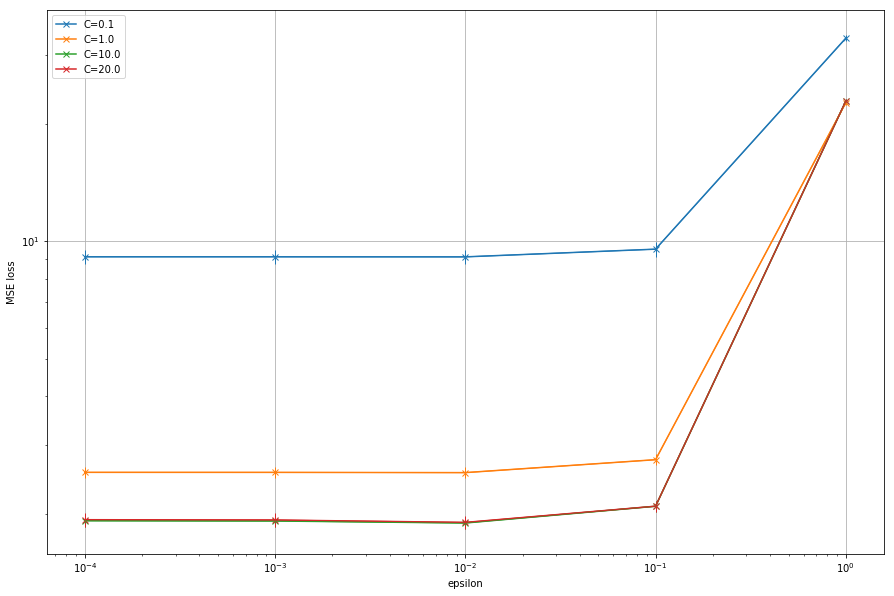

Min loss:
{'history_steps': 1, 'model': {'epsilon': 0.01, 'C': 10.0, 'verbose': True}, 'l2_std': 0.0689759784280909, 'l2_mean': 1.896936168731245}

{'history_steps': 1, 'model': {'epsilon': 0.0001, 'C': 10.0, 'verbose': True}, 'l2_std': 0.06938611517111747, 'l2_mean': 1.922422543510463}
{'history_steps': 1, 'model': {'epsilon': 0.001, 'C': 10.0, 'verbose': True}, 'l2_std': 0.06938100085144248, 'l2_mean': 1.9195504728106374}
{'history_steps': 1, 'model': {'epsilon': 0.01, 'C': 10.0, 'verbose': True}, 'l2_std': 0.0689759784280909, 'l2_mean': 1.896936168731245}
{'history_steps': 1, 'model': {'epsilon': 0.0001, 'C': 20, 'verbose': True}, 'l2_std': 0.0771619127262914, 'l2_mean': 1.934334994814344}
{'history_steps': 1, 'model': {'epsilon': 0.001, 'C': 20, 'verbose': True}, 'l2_std': 0.07709787792259568, 'l2_mean': 1.930982200729554}
{'history_steps': 1, 'model': {'epsilon': 0.01, 'C': 20, 'verbose': True}, 'l2_std': 0.07572464725760647, 'l2_mean': 1.903755372649437}


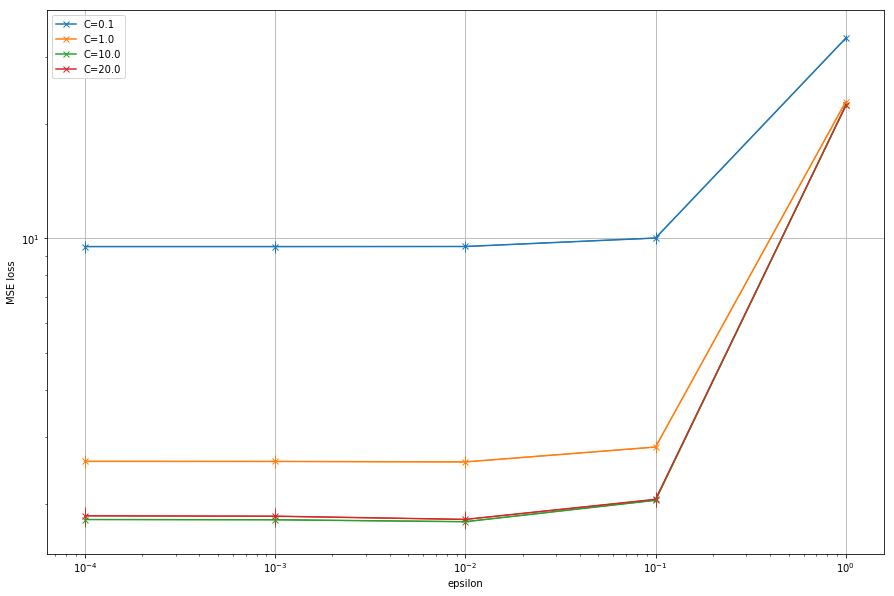

Min loss:
{'history_steps': 3, 'model': {'epsilon': 0.01, 'C': 10.0, 'verbose': True}, 'l2_std': 0.08074445352568509, 'l2_mean': 1.7991280458716445}

{'history_steps': 3, 'model': {'epsilon': 0.0001, 'C': 10.0, 'verbose': True}, 'l2_std': 0.08017952524228932, 'l2_mean': 1.8229359916208978}
{'history_steps': 3, 'model': {'epsilon': 0.001, 'C': 10.0, 'verbose': True}, 'l2_std': 0.08031971634100672, 'l2_mean': 1.8205202441671051}
{'history_steps': 3, 'model': {'epsilon': 0.01, 'C': 10.0, 'verbose': True}, 'l2_std': 0.08074445352568509, 'l2_mean': 1.7991280458716445}
{'history_steps': 3, 'model': {'epsilon': 0.0001, 'C': 20, 'verbose': True}, 'l2_std': 0.09759291678007372, 'l2_mean': 1.8643193554894169}
{'history_steps': 3, 'model': {'epsilon': 0.001, 'C': 20, 'verbose': True}, 'l2_std': 0.09768576295161978, 'l2_mean': 1.860110678790777}
{'history_steps': 3, 'model': {'epsilon': 0.01, 'C': 20, 'verbose': True}, 'l2_std': 0.09599599772491395, 'l2_mean': 1.824314363185072}


In [27]:
def plot_params(params):    
    fig, axes = plt.subplots(1, 1, figsize=(15, 10))
    
    for i, C in enumerate(np.unique([p['model']['C'] for p in params])):
        ax = axes

        pars = [p for p in params if p['model']['C'] == C]
        x = [p['model']['epsilon'] for p in pars]
        y = [p['l2_mean'] for p in pars]
        yerr = [p['l2_std'] for p in pars]

        ax.set_yscale("log", nonposy='clip')
        ax.set_xscale("log", nonposx='clip')

        p = ax.plot(x, y, 'x-', label="C=%.1f" % (C))
        ax.errorbar(x, y ,yerr=yerr, linewidth=1, color=p[0].get_color())

    plt.xlabel('epsilon')
    plt.ylabel('MSE loss')
    plt.grid()
    plt.legend()
    plt.show()


    l2_mean = [p['l2_mean'] for p in params]
    l2_std = [p['l2_std'] for p in params]
    min_idx = np.argmin(l2_mean)

    print 'Min loss:'
    print params[min_idx]
    print ''

    param_stdrule = [p for p in params if p['l2_mean'] < params[min_idx]['l2_mean'] + params[min_idx]['l2_std']]
    for p in param_stdrule:
        print p

for history_steps in np.unique([p['history_steps'] for p in params]):
    plot_params([p for p in params if p['history_steps'] == history_steps])


# for C in np.unique([p['C'] for p in params]):
#     pars = [p for p in params if p['C'] == C]
#     x = [p['epsilon'] for p in pars]
#     y = [p['l2_loss'] for p in pars]

#     plt.loglog(x, y, 'x-', label="C=%0.1f" % (C))
    
# plt.xlabel('epsilon')
# plt.ylabel('MSE loss')
# plt.grid()
# plt.legend()

# Validation

In [4]:
best_params = [
    {
        'history_steps': 1,
        'model': {
            'epsilon': 0.01, 'C': 10.0, 'verbose': True
        },
    }, {
        'history_steps': 3,
        'model': {
            'epsilon': 0.01, 'C': 10.0, 'verbose': True
        },
    }
]

for param in best_params:
    xtr, ytr = split_data(sarcos_inv, param['history_steps'])
    xts, yts = split_data(sarcos_inv_test, param['history_steps'])
    
    model = MultidimSVR(param['model'])
    model.fit(xtr[::5], ytr[::5], True)

    yhat = model.predict(xtr)
    MSE_tr = np.mean(scaler_y.inverse_transform(yts) - scaler_y.inverse_transform(yhat))**2)
    
    yhat = model.predict(xts)
    MSE_ts = np.mean(scaler_y.inverse_transform(yts) - scaler_y.inverse_transform(yhat))**2)
    
    print 'Params:', param
    print 'MSE train:', MSE_tr
    print 'MSE test: ', MSE_ts
    print ''

[LibSVM](SVR fit took 13.8 sec)
[LibSVM](SVR fit took 14.0 sec)
[LibSVM](SVR fit took 25.3 sec)
[LibSVM](SVR fit took 27.4 sec)
[LibSVM](SVR fit took 51.0 sec)
[LibSVM](SVR fit took 50.2 sec)
[LibSVM](SVR fit took 47.4 sec)
Params: {'history_steps': 1, 'model': {'epsilon': 0.01, 'C': 10.0, 'verbose': True}}
MSE train: 41.429458467213664
MSE test:  23.722563883858825

[LibSVM](SVR fit took 12.6 sec)
[LibSVM](SVR fit took 12.6 sec)
[LibSVM](SVR fit took 24.1 sec)
[LibSVM](SVR fit took 25.7 sec)
[LibSVM](SVR fit took 39.6 sec)
[LibSVM](SVR fit took 34.2 sec)
[LibSVM](SVR fit took 41.8 sec)
Params: {'history_steps': 3, 'model': {'epsilon': 0.01, 'C': 10.0, 'verbose': True}}
MSE train: 46.03539199449951
MSE test:  130.5331551436593

